# LAB: Multiobjective optimization


## 1 - Imports

In [2]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import sys

options = {
    "font_size": 20,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    "with_labels": True,
}

## 2 - Linear programs

In [3]:
def minimize_routing_cost(graph: nx.DiGraph, routing_demand: nx.DiGraph, max_cost: float = 0.0, max_network_traffic: float = 0.0, max_arc_traffic: float = 0.0):

    model = gp.Model("multiobjective")

    # Create variables
    x = {}
    for i,j in routing_demand.edges():
        for k,l in graph.edges():
            x[i,j,k,l] = model.addVar(lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS , name = f"x[{i},{j},{k},{l}]")

    # Constraints on outgoing traffic from suppliers
    model.addConstrs(gp.quicksum(x[i,j,i,k] for k in graph.succ[i]) == 1 for i,j in routing_demand.edges())
    
    # Constraints on incoming volume to receivent
    model.addConstrs(gp.quicksum(x[i,j,k,j] for k in graph.pred[j]) == 1 for i,j in routing_demand.edges())

    # Constraints on incoming traffic from suppliers (should be 0)
    model.addConstrs(x[i,j,k,i] == 0 for i,j in routing_demand.edges() for k in graph.succ[i] if graph.has_edge(k,i) )

    # Constraint on Kirchhoff's junction rule
    model.addConstrs(gp.quicksum(x[i,j,k,l] for l in graph.succ[k]) == gp.quicksum(x[i,j,l,k] for l in graph.pred[k]) for i,j in routing_demand.edges() for k in graph.nodes() if k not in (i,j))

    # Constraint on arc capacity
    model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges()) <= graph[k][l]["capacity"] for k,l in graph.edges())

    # Constraint on maximum cost (if set)
    if (max_cost):
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] * graph[k][l]["cost"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_cost)

    # Constraint on maximum total traffic (if set)
    if max_network_traffic:
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_network_traffic)

    # Constraints on maximum arc traffic (if set)
    if max_arc_traffic:
        model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i, j in routing_demand.edges()) <= max_arc_traffic for k,l in graph.edges())


    # Minimizing the cost
    model.setObjective(
        gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] * graph[k][l]["cost"] for i,j in routing_demand.edges() for k,l in graph.edges())
        , GRB.MINIMIZE
    )


    # Optimize the model (and write it for debugging purposes)
    model.setParam('OutputFlag', 0)
    model.optimize()


    # Display solution
    if model.Status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED):
        print("The model cannot be solved because it is infeasible or "
              "unbounded")
        sys.exit(1)

    if model.Status != GRB.OPTIMAL:
        print('Optimization was stopped with status ' + str(model.Status))
        sys.exit(1)

    cost = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] * graph[k][l]['cost'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    total_traffic = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    maximum_arc_traffic = max(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    result = nx.DiGraph()
    for k in graph:
        for l in graph.succ[k]:
            sum_traffic = sum(
                x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges()
            )
            if (sum_traffic):
                result.add_edge(k, l, traffic = sum_traffic)

    return (cost, total_traffic, maximum_arc_traffic, result)

In [4]:
def minimize_total_arc_usage(graph: nx.DiGraph, routing_demand: nx.DiGraph, max_cost: float = 0.0, max_network_traffic: float = 0.0, max_arc_traffic: float = 0.0):

    model = gp.Model("multiobjective")
    
    # Create variables
    x = {}
    for i,j in routing_demand.edges():
        for k,l in graph.edges():
            x[i,j,k,l] = model.addVar(lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS , name = f"x[{i},{j},{k},{l}]")

    # Constraints on outgoing traffic from suppliers
    model.addConstrs(gp.quicksum(x[i,j,i,k] for k in graph.succ[i]) == 1 for i,j in routing_demand.edges())
    
    # Constraints on incoming volume to receivent
    model.addConstrs(gp.quicksum(x[i,j,k,j] for k in graph.pred[j]) == 1 for i,j in routing_demand.edges())

    # Constraints on incoming traffic from suppliers (should be 0)
    model.addConstrs(x[i,j,k,i] == 0 for i,j in routing_demand.edges() for k in graph.succ[i] if graph.has_edge(k,i) )

    # Constraint on Kirchhoff's junction rule
    model.addConstrs(gp.quicksum(x[i,j,k,l] for l in graph.succ[k]) == gp.quicksum(x[i,j,l,k] for l in graph.pred[k]) for i,j in routing_demand.edges() for k in graph.nodes() if k not in (i,j))

    # Constraint on arc capacity
    model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges()) <= graph[k][l]["capacity"] for k,l in graph.edges())

    # Constraint on maximum cost (if set)
    if (max_cost):
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] * graph[k][l]["cost"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_cost)

    # Constraint on maximum network traffic (if set)
    if max_network_traffic:
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_network_traffic)

    # Constraints on maximum arc traffic (if set)
    if max_arc_traffic:
        model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i, j in routing_demand.edges()) <= max_arc_traffic for k,l in graph.edges())


    # Minimizing the total arc usage
    model.setObjective(
        gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges() for k,l in graph.edges())
        , GRB.MINIMIZE
    )

    # Optimize the model (and write it for debugging purposes)
    model.setParam('OutputFlag', 0)
    model.optimize()


    # Display solution
    if model.Status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED):
        print("The model cannot be solved because it is infeasible or "
              "unbounded")
        sys.exit(1)

    if model.Status != GRB.OPTIMAL:
        print('Optimization was stopped with status ' + str(model.Status))
        sys.exit(1)

    cost = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] * graph[k][l]['cost'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    total_traffic = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    maximum_arc_traffic = max(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    result = nx.DiGraph()
    for k in graph:
        for l in graph.succ[k]:
            sum_traffic = sum(
                x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges()
            )
            if (sum_traffic):
                result.add_edge(k, l, traffic = sum_traffic)

    return (cost, total_traffic, maximum_arc_traffic, result)

In [5]:
def minimize_maximum_arc_usage(graph: nx.DiGraph, routing_demand: nx.DiGraph, max_cost: float = 0.0, max_network_traffic: float = 0.0, max_arc_traffic: float = 0.0):

    model = gp.Model("multiobjective")

    # Create variables
    x = {}
    for i,j in routing_demand.edges():
        for k,l in graph.edges():
            x[i,j,k,l] = model.addVar(lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS , name = f"x[{i},{j},{k},{l}]")

    # Constraints on outgoing traffic from suppliers
    model.addConstrs(gp.quicksum(x[i,j,i,k] for k in graph.succ[i]) == 1 for i,j in routing_demand.edges())
    
    # Constraints on incoming volume to receivent
    model.addConstrs(gp.quicksum(x[i,j,k,j] for k in graph.pred[j]) == 1 for i,j in routing_demand.edges())

    # Constraints on incoming traffic from suppliers (should be 0)
    model.addConstrs(x[i,j,k,i] == 0 for i,j in routing_demand.edges() for k in graph.succ[i] if graph.has_edge(k,i) )

    # Constraint on Kirchhoff's junction rule
    model.addConstrs(gp.quicksum(x[i,j,k,l] for l in graph.succ[k]) == gp.quicksum(x[i,j,l,k] for l in graph.pred[k]) for i,j in routing_demand.edges() for k in graph.nodes() if k not in (i,j))

    # Constraint on arc capacity
    model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges()) <= graph[k][l]["capacity"] for k,l in graph.edges())

    # Constraint on maximum cost (if set)
    if (max_cost):
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] * graph[k][l]["cost"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_cost)

    # Constraint on maximum total traffic (if set)
    if max_network_traffic:
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_network_traffic)

    # Constraints on maximum arc traffic (if set)
    if max_arc_traffic:
        model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i, j in routing_demand.edges()) <= max_arc_traffic for k,l in graph.edges())


    # Minimizing the maximum use of an arc
    max_use = model.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name="max_traffic")
    for k,l in graph.edges():
        model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges()) <= max_use)
    model.setObjective(max_use, GRB.MINIMIZE)



    # Optimize the model (and write it for debugging purposes)
    model.setParam('OutputFlag', 0)
    model.optimize()


    # Display solution
    if model.Status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED):
        print("The model cannot be solved because it is infeasible or "
              "unbounded")
        sys.exit(1)

    if model.Status != GRB.OPTIMAL:
        print('Optimization was stopped with status ' + str(model.Status))
        sys.exit(1)

    cost = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] * graph[k][l]['cost'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    total_traffic = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    maximum_arc_traffic = max(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    result = nx.DiGraph()
    for k in graph:
        for l in graph.succ[k]:
            sum_traffic = sum(
                x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges()
            )
            if (sum_traffic):
                result.add_edge(k, l, traffic = sum_traffic)

    return (cost, total_traffic, maximum_arc_traffic, result)

## 3 - Tests with some instances

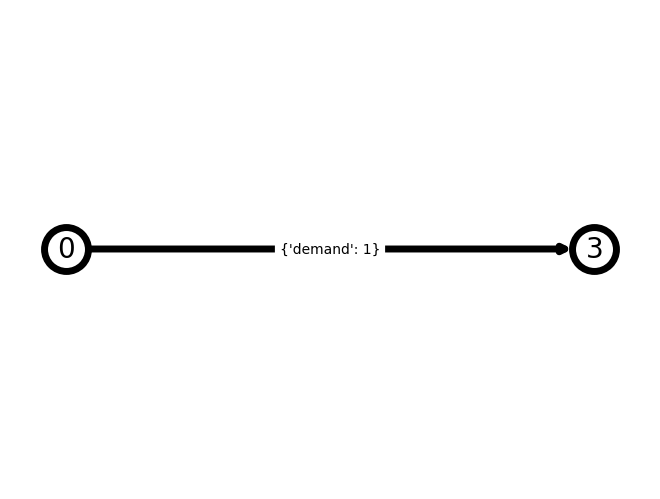

In [6]:
routing_demand = nx.DiGraph()
routing_demand.add_edge(0, 3, demand=1)
pos = {0: (0,0), 1: (1, 1), 2: (3, 1), 3: (4,0), 4: (3, -1), 5: (1, -1), 6: (2, 0)}
nx.draw(routing_demand, pos, **options)
nx.draw_networkx_edge_labels(routing_demand, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/routing_demand.png")
plt.show()

### 3.1- Cycles

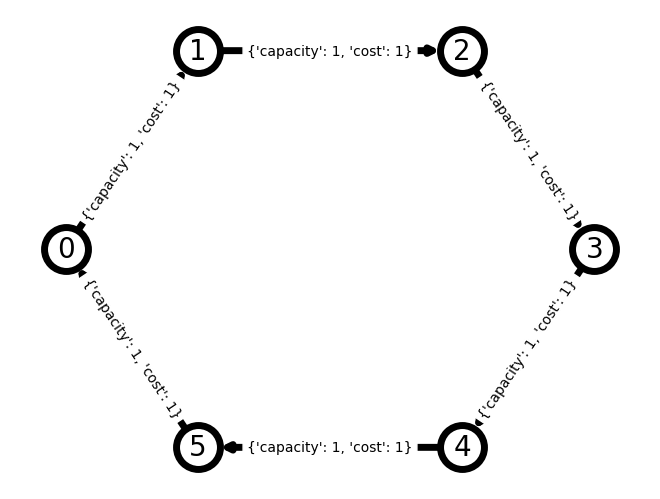

In [7]:
graph = nx.DiGraph()
SIZE = 6
for i in range(SIZE):
    graph.add_edge(i, (i+1) % SIZE  , capacity = 1, cost = 1)

nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)

plt.gca()
plt.axis("off")
plt.savefig("../images/cycle_graph.png")
plt.show()

Restricted license - for non-production use only - expires 2024-10-28


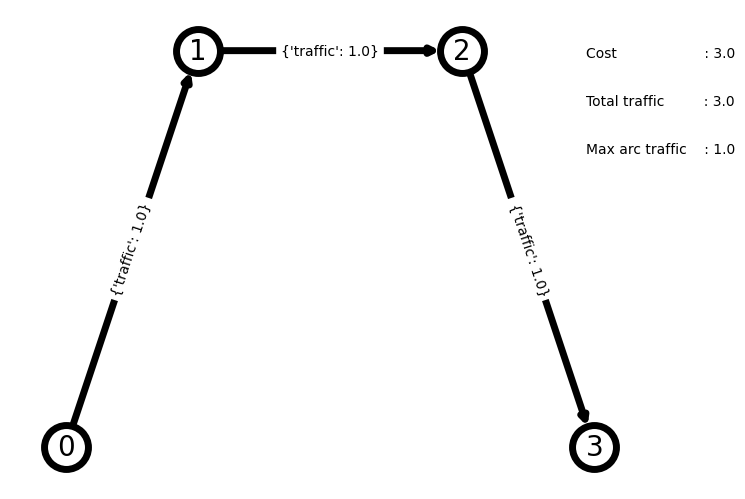

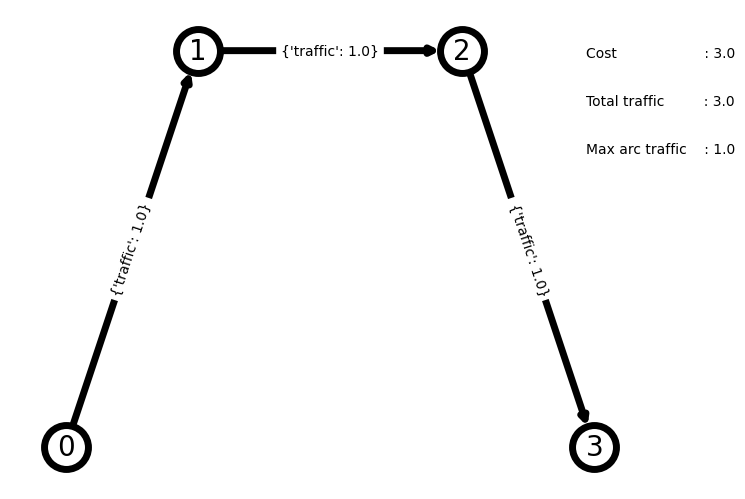

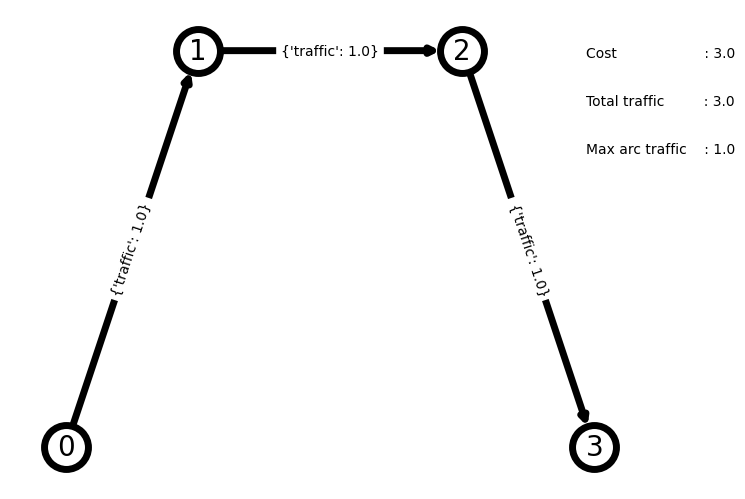

In [8]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/cycle_minimize_routing_cost.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/cycle_minimize_total_traffic.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/cycle_minimize_maximum_arc_usage.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


### 3.2 - Complete graph

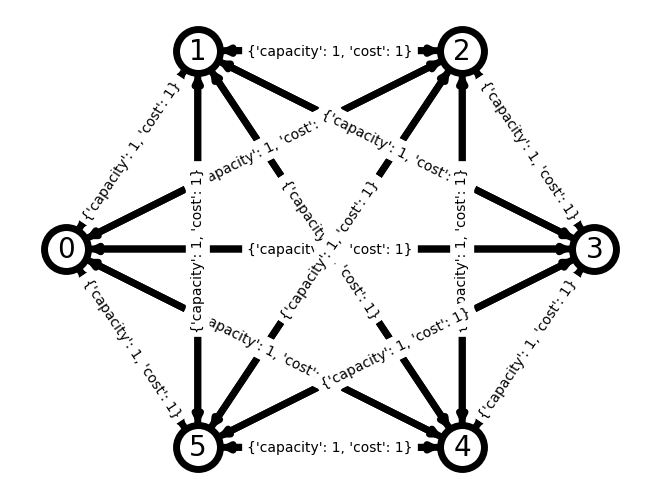

In [9]:
graph = nx.DiGraph()
SIZE = 6
for i in range(SIZE):
    for j in range(SIZE):
        if i != j:
            graph.add_edge(i, j, capacity = 1, cost = 1)

nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)

plt.gca()
plt.savefig("../images/complete_graph.png")
plt.axis("off")
plt.show()

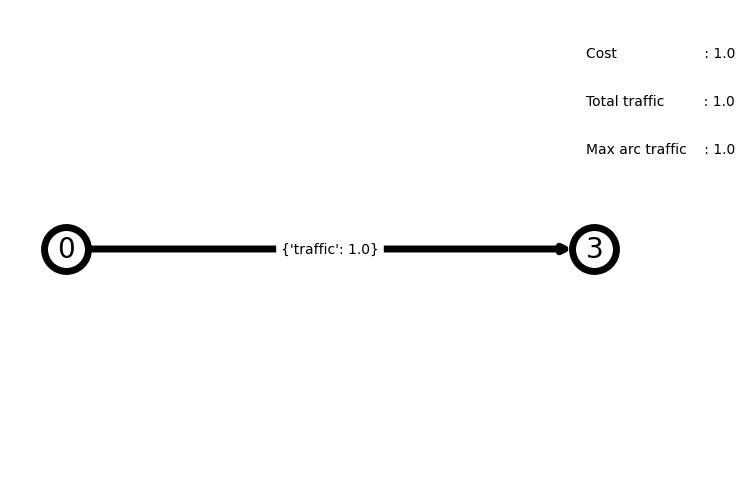

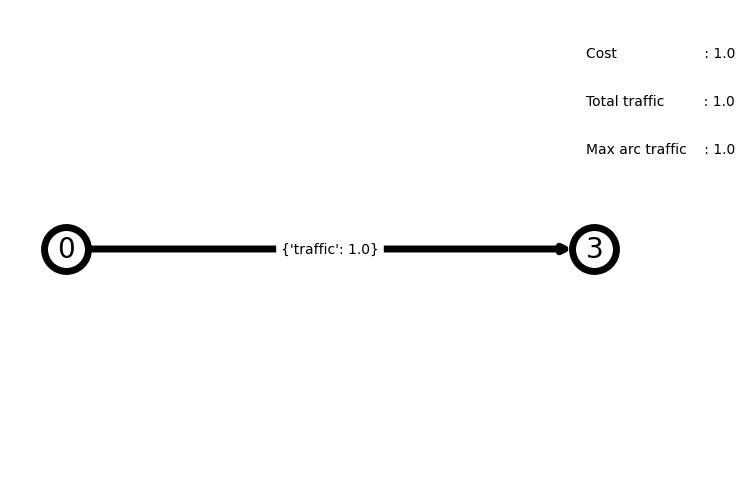

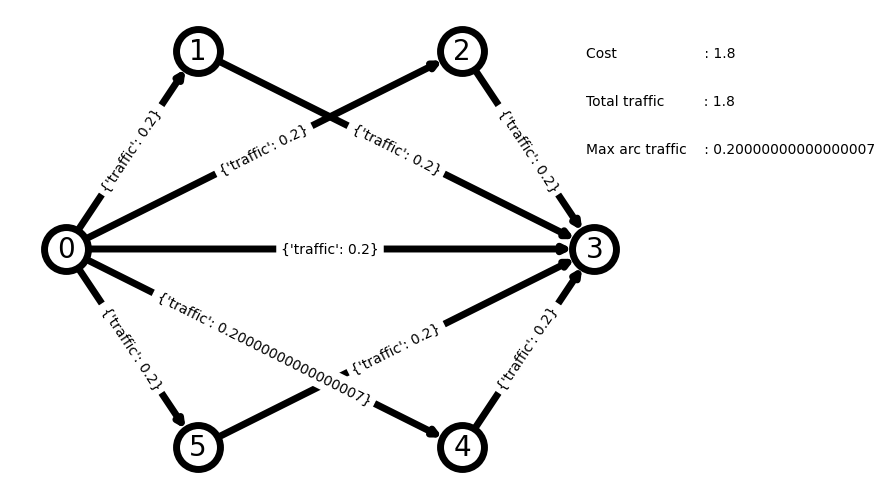

In [10]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/complete_minimize_routing_cost.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/complete_minimize_total_traffic.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/complete_minimize_maximum_arc_usage.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

## 3.3 - Star graph

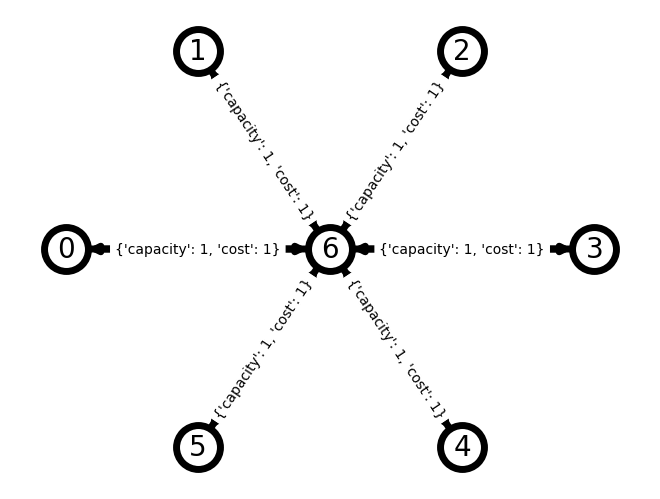

In [11]:
graph = nx.DiGraph()
SIZE = 6
for i in range(SIZE):
    graph.add_edge(i, SIZE, capacity = 1, cost = 1)
    graph.add_edge(SIZE, i, capacity = 1, cost = 1)

nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)

plt.gca()
plt.axis("off")
plt.savefig("../images/star_graph.png")
plt.show()

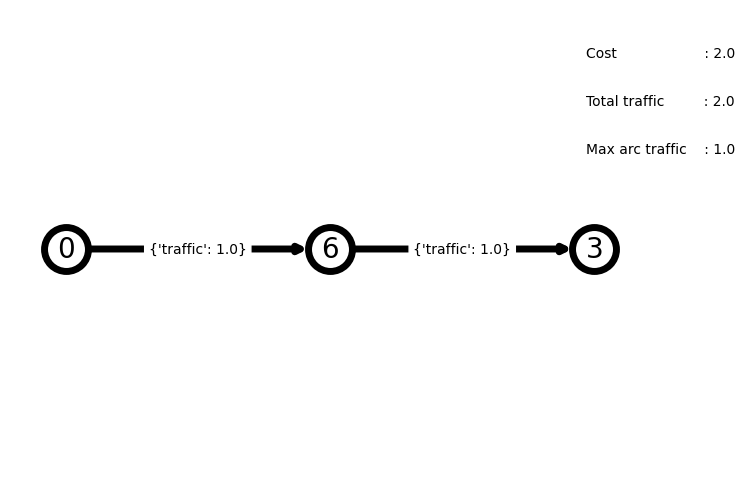

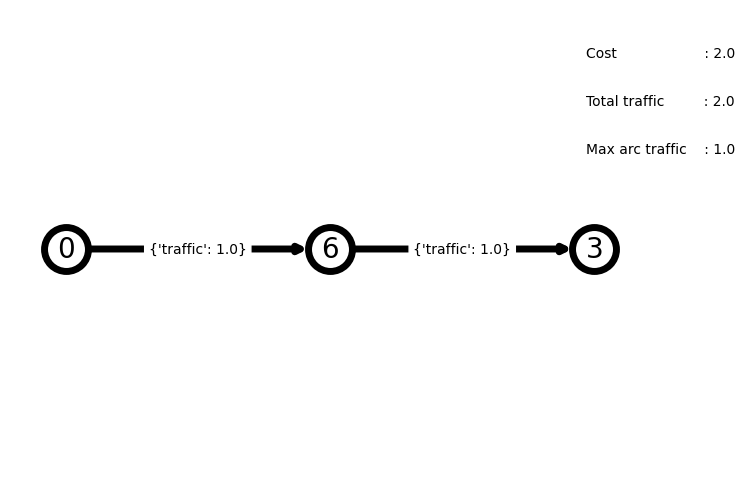

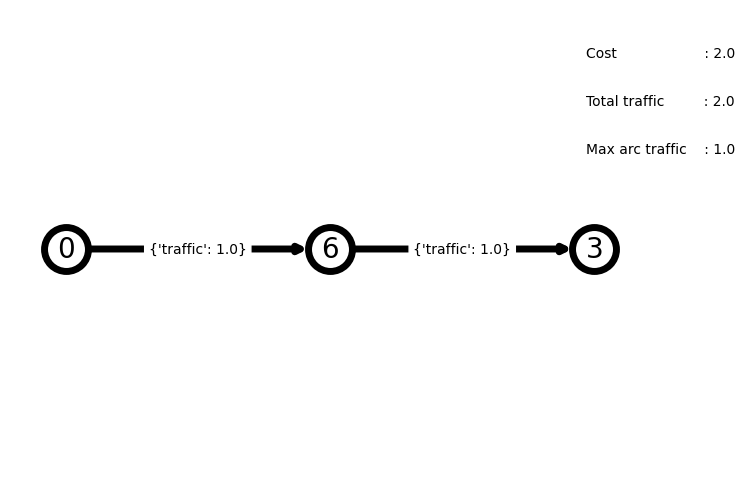

In [12]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/star_minimize_routing_cost.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/star_minimize_total_traffic.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/star_minimize_maximum_arc_usage.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

### 3.3 - Random graph


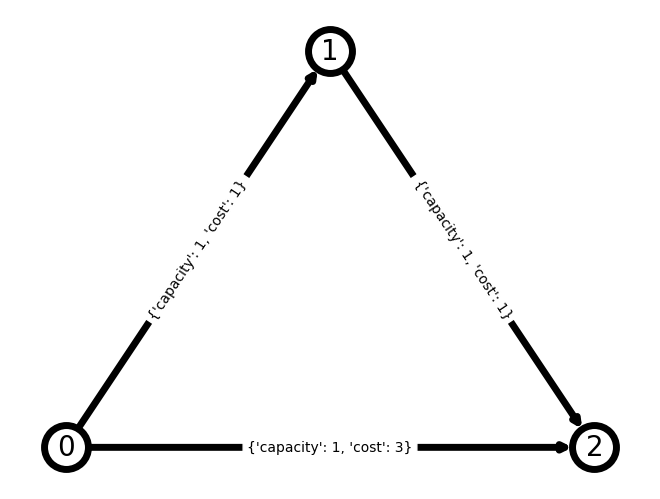

In [13]:
graph = nx.DiGraph()
graph.add_edge(0,2, capacity = 1, cost = 3)
graph.add_edge(0,1, capacity = 1, cost = 1)
graph.add_edge(1,2, capacity = 1, cost = 1)

pos = {0: (0,0), 1: (1, 1), 2: (2, 0)}

nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/random_graph.png")
plt.show()

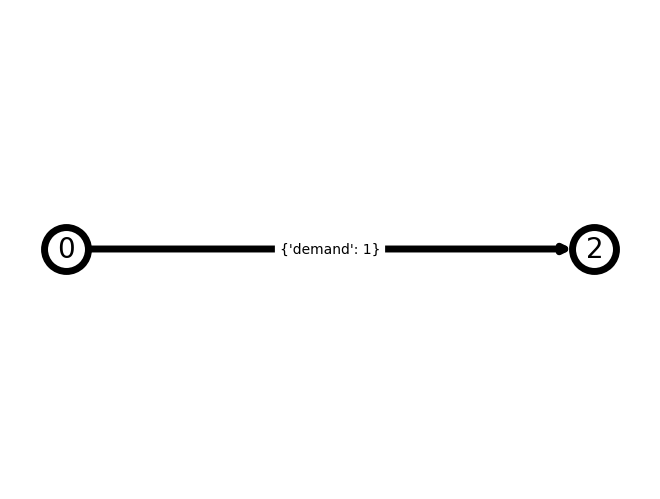

In [14]:
routing_demand = nx.DiGraph()
routing_demand.add_edge(0,2, demand=1)

nx.draw(routing_demand, pos, **options)
nx.draw_networkx_edge_labels(routing_demand, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/random_routing_demand.png")
plt.show()

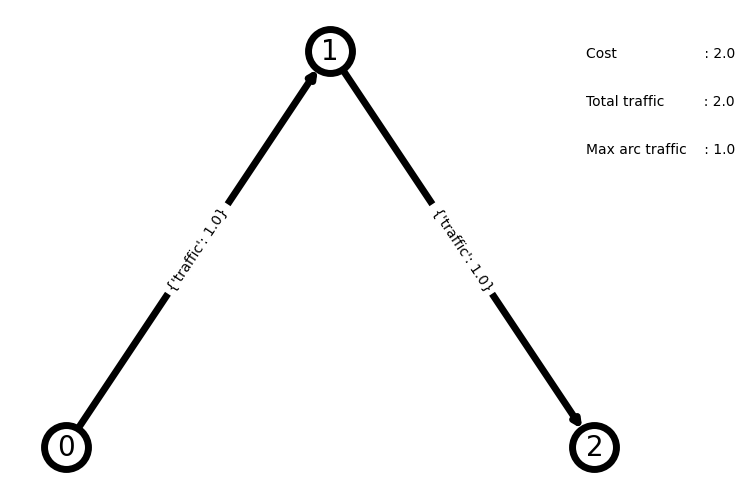

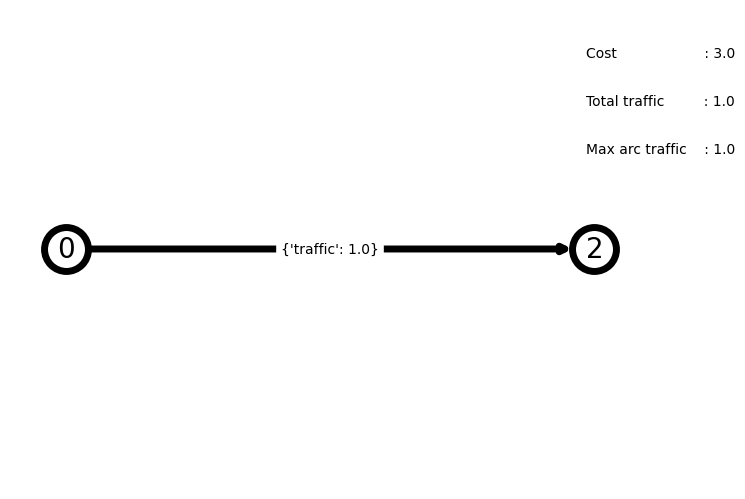

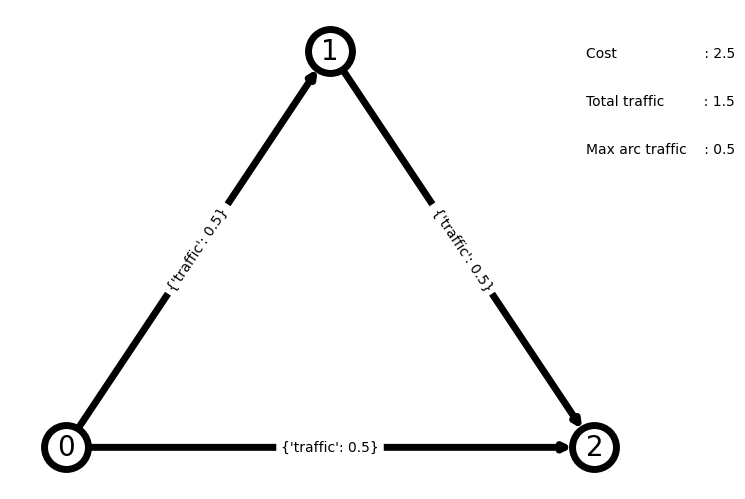

In [15]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/random_minimize_routing_cost.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/random_minimize_total_traffic.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/random_minimize_maximum_arc_usage.png")
plt.figtext(.9, 0.9, f"Cost                    : {cost}")
plt.figtext(.9, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(.9, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

### 3-4 : Random internet as graph



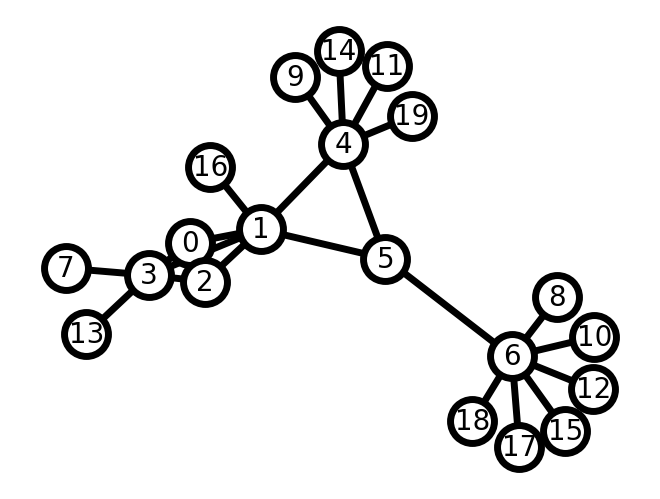

In [16]:
graph = nx.random_internet_as_graph(20, 4)
pos=nx.spring_layout(graph)
nx.set_edge_attributes(graph, 5, 'capacity')
nx.set_edge_attributes(graph, 1, 'cost')
nx.draw(graph, pos, **options)
# nx.draw_networkx_edge_labels(graph, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/internet_graph.png")
plt.show()
graph = graph.to_directed()


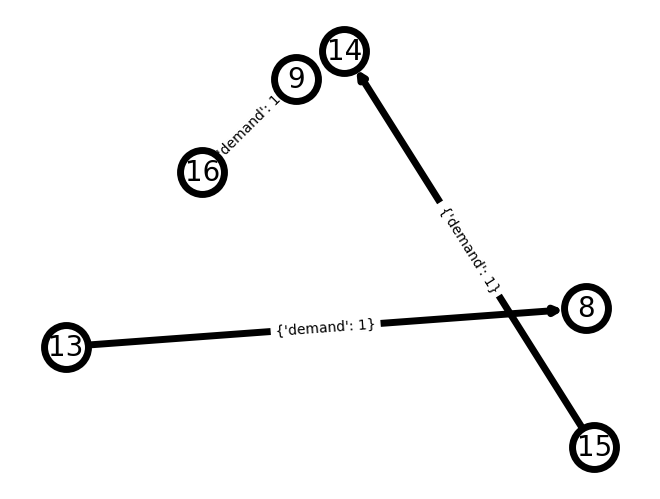

In [17]:
routing_demand = nx.DiGraph()
routing_demand.add_edge(13,8, demand=1)
routing_demand.add_edge(15,14, demand=1)
routing_demand.add_edge(16,9, demand=1)

nx.draw(routing_demand, pos, **options)
nx.draw_networkx_edge_labels(routing_demand, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/internet_routing_demand.png")
plt.show()

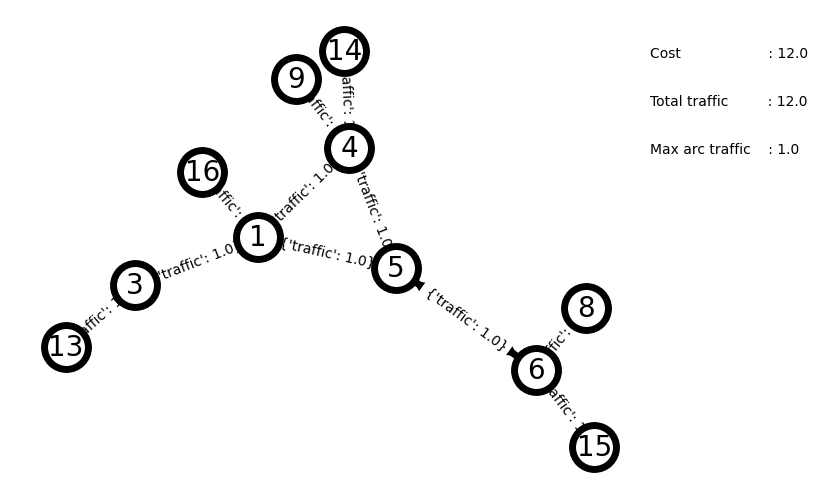

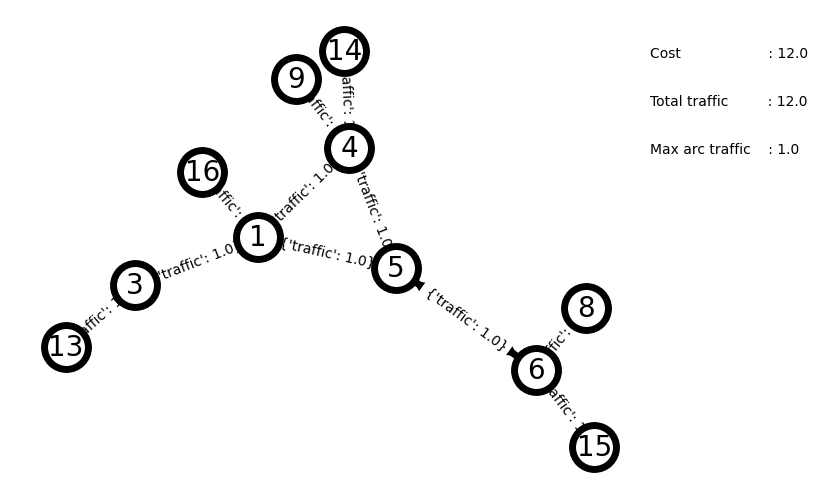

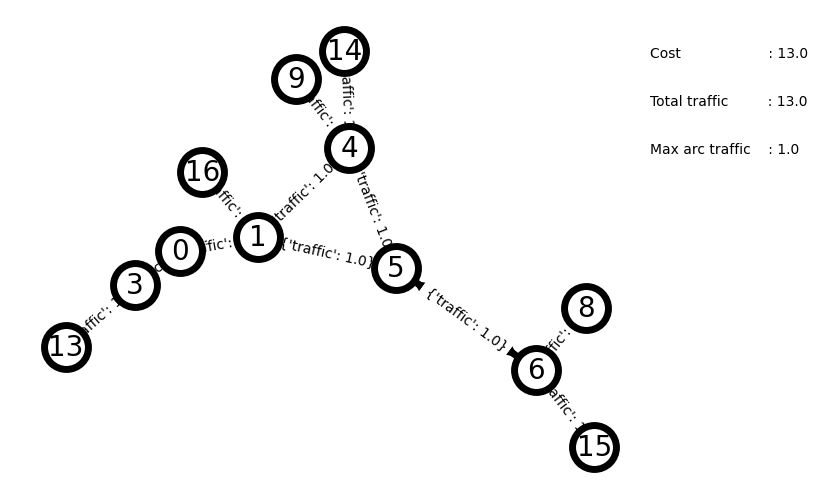

In [18]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/internet_minimize_routing_cost.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/internet_minimize_total_traffic.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/internet_minimize_maximum_arc_usage.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

## 4 - Pareto efficient solutions

Firstly, we need to create a problem that can benefit from lexicographic optimization.

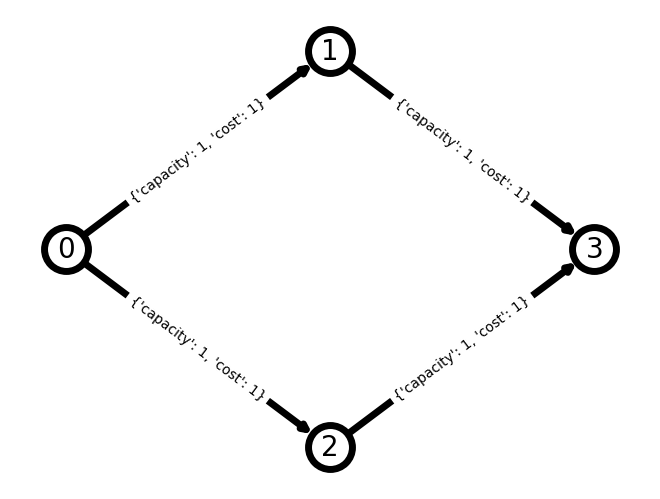

In [19]:
graph = nx.DiGraph()
graph.add_edge(0, 1, capacity = 1, cost = 1)
graph.add_edge(1, 3, capacity = 1, cost = 1)
graph.add_edge(0, 2, capacity = 1, cost = 1)
graph.add_edge(2, 3, capacity = 1, cost = 1)

pos = {0: (0,0), 1: (2, 1), 2: (2, -1), 3: (4, 0)}
nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_graph.png")
plt.show()

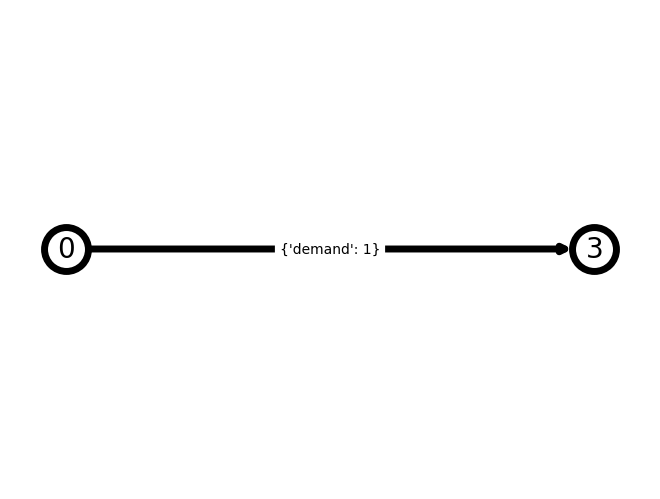

In [20]:
routing_demand = nx.DiGraph()
routing_demand.add_edge(0, 3, demand=1)

pos = {0: (0,0), 1: (2, 1), 2: (2, -1), 3: (4, 0)}
nx.draw(routing_demand, pos, **options)
nx.draw_networkx_edge_labels(routing_demand, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_routing_demand.png")
plt.show()

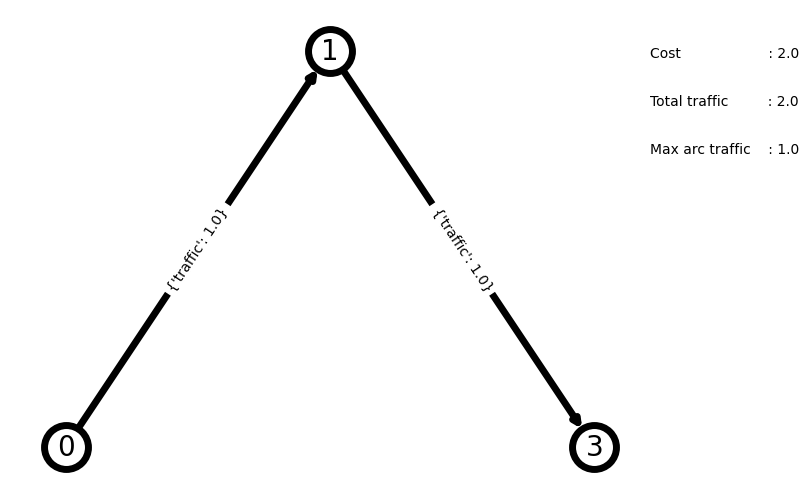

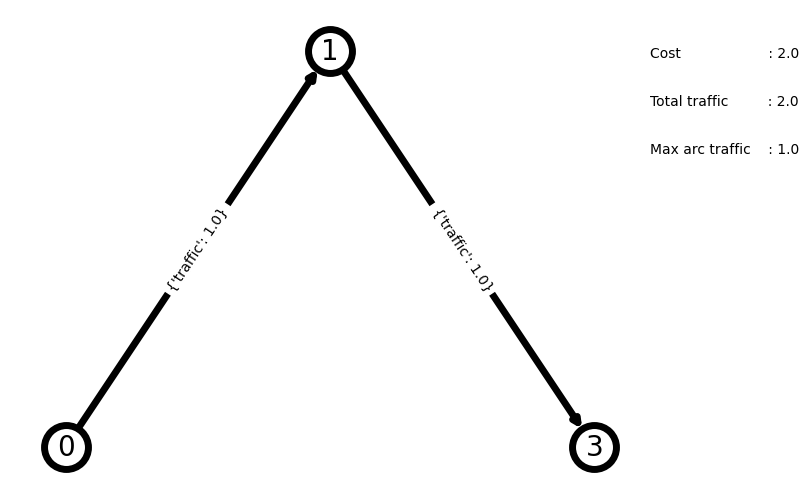

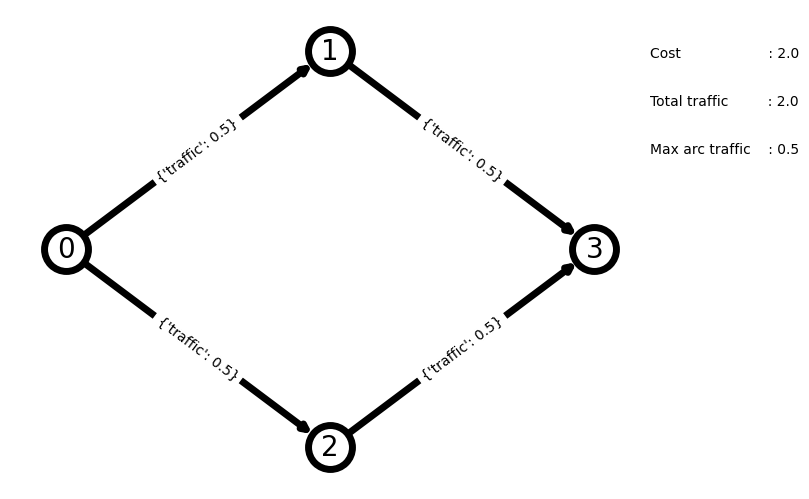

In [21]:
cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_minimize_routing_cost.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()


cost, total_traffic, maximum_arc_traffic, result = minimize_total_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_minimize_total_traffic.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

cost, total_traffic, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand)
nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_minimize_maximum_arc_usage.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

### 4.1 - Lexicographic optimization

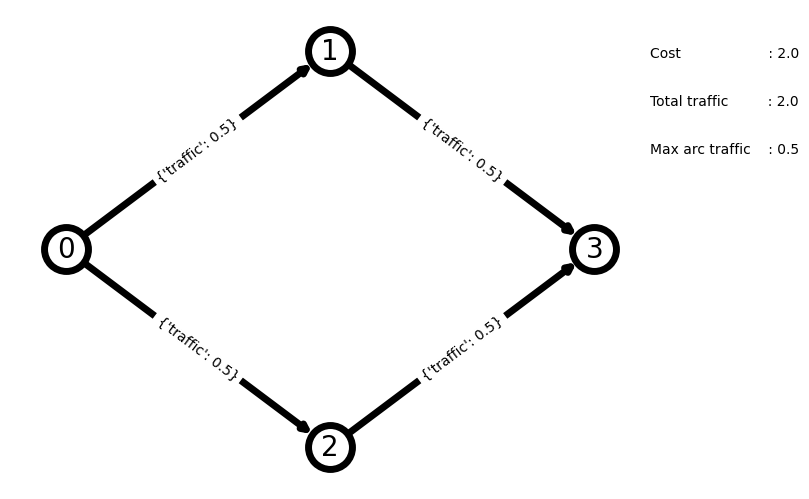

In [22]:
cost, _, _, _ = minimize_routing_cost(graph, routing_demand)
_, total_traffic, _, _ = minimize_total_arc_usage(graph, routing_demand, max_cost=cost)
_, _, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand, max_cost=cost, max_network_traffic=total_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/pareto_minimize_cta.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

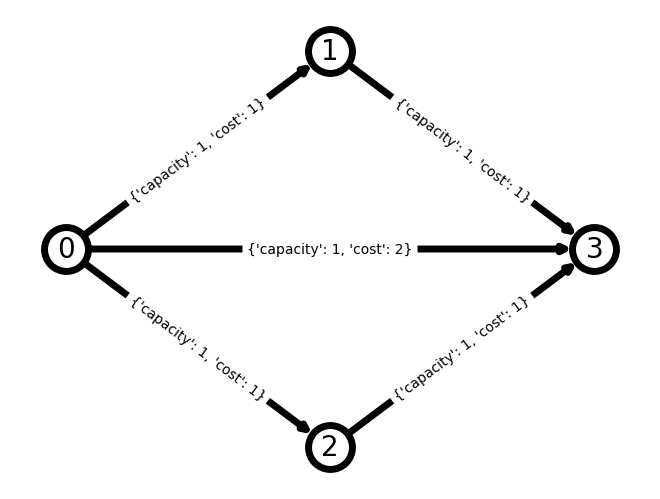

In [23]:
graph = nx.DiGraph()
graph.add_edge(0, 1, capacity = 1, cost = 1)
graph.add_edge(0, 3, capacity = 1, cost = 2)
graph.add_edge(1, 3, capacity = 1, cost = 1)
graph.add_edge(0, 2, capacity = 1, cost = 1)
graph.add_edge(2, 3, capacity = 1, cost = 1)

pos = {0: (0,0), 1: (2, 1), 2: (2, -1), 3: (4, 0)}
nx.draw(graph, pos, **options)
nx.draw_networkx_edge_labels(graph, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/lexicographic_graph.png")
plt.show()

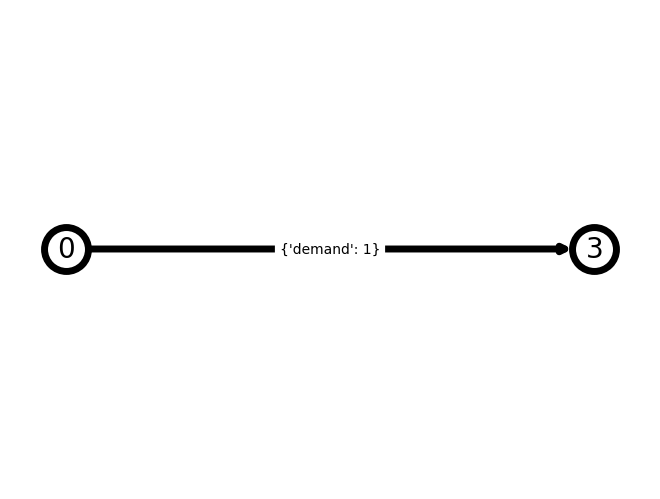

In [24]:
routing_demand = nx.DiGraph()
routing_demand.add_edge(0, 3, demand=1)

pos = {0: (0,0), 1: (2, 1), 2: (2, -1), 3: (4, 0)}
nx.draw(routing_demand, pos, **options)
nx.draw_networkx_edge_labels(routing_demand, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/lexicographic_routing_demand.png")
plt.show()

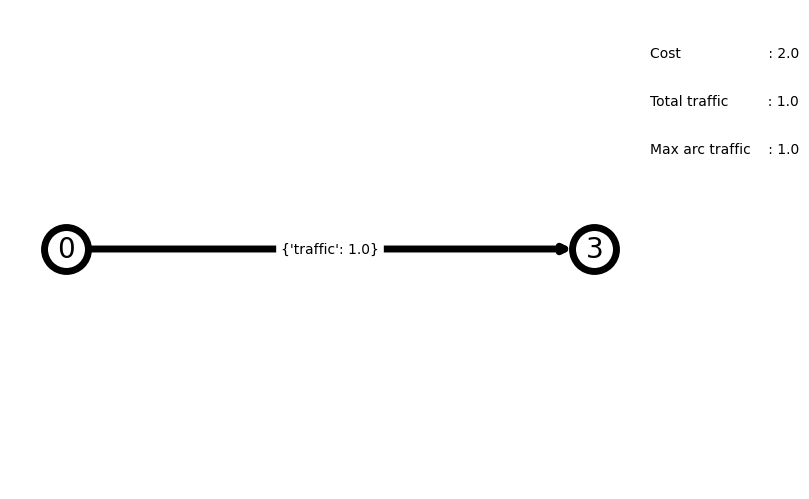

In [25]:
cost = float('inf')
total_traffic = float('inf')
maximum_arc_traffic = float('inf')

cost, _, _, result = minimize_routing_cost(graph, routing_demand, max_arc_traffic=maximum_arc_traffic, max_network_traffic=total_traffic)
_, total_traffic, _, result = minimize_total_arc_usage(graph, routing_demand, max_cost=cost, max_arc_traffic=maximum_arc_traffic)
_, _, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand, max_cost=cost, max_network_traffic=total_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/lexicographic_minimize_ta.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

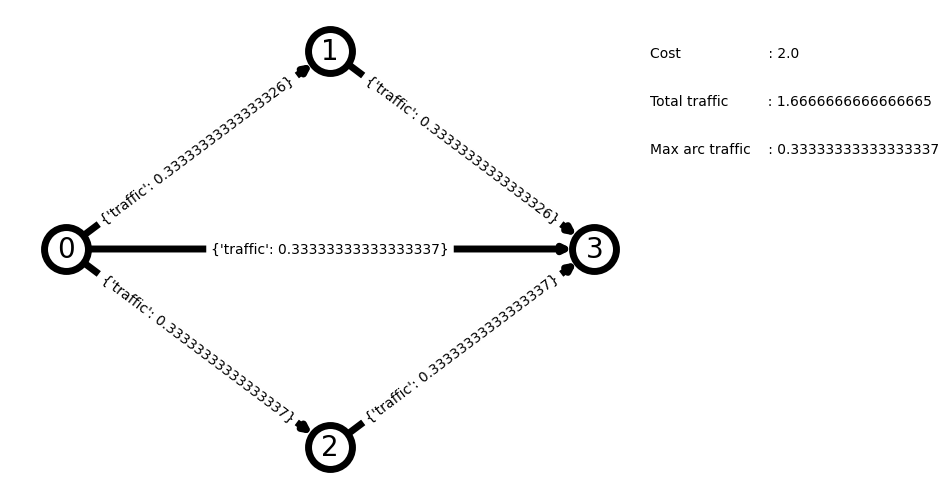

In [26]:
cost = float('inf')
total_traffic = float('inf')
maximum_arc_traffic = float('inf')

cost, _, _, result = minimize_routing_cost(graph, routing_demand, max_arc_traffic=maximum_arc_traffic, max_network_traffic=total_traffic)
_, _, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand, max_cost=cost, max_network_traffic=total_traffic)
_, total_traffic, _, result = minimize_total_arc_usage(graph, routing_demand, max_cost=cost, max_arc_traffic=maximum_arc_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/lexicographic_minimize_at.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

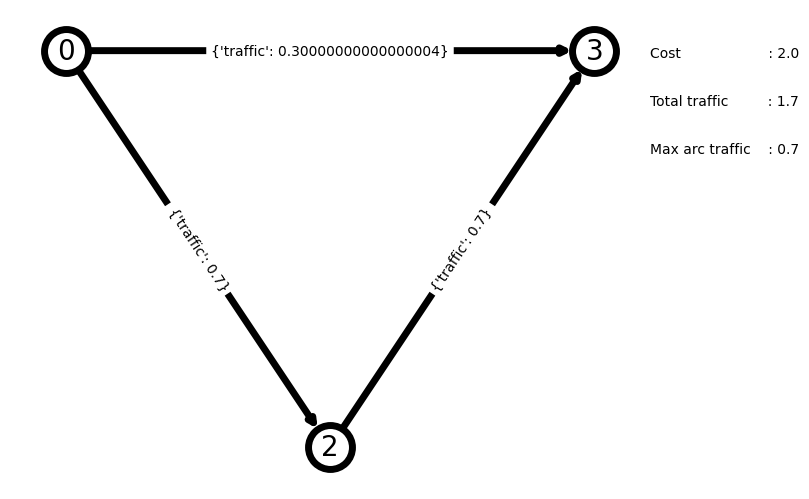

In [33]:
cost = float('inf')
total_traffic = float('inf')
maximum_arc_traffic = 0.7

cost, total_traffic, maximum_arc_traffic, result = minimize_routing_cost(graph, routing_demand, max_arc_traffic=0.7)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/epsilon_0.7_cost.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

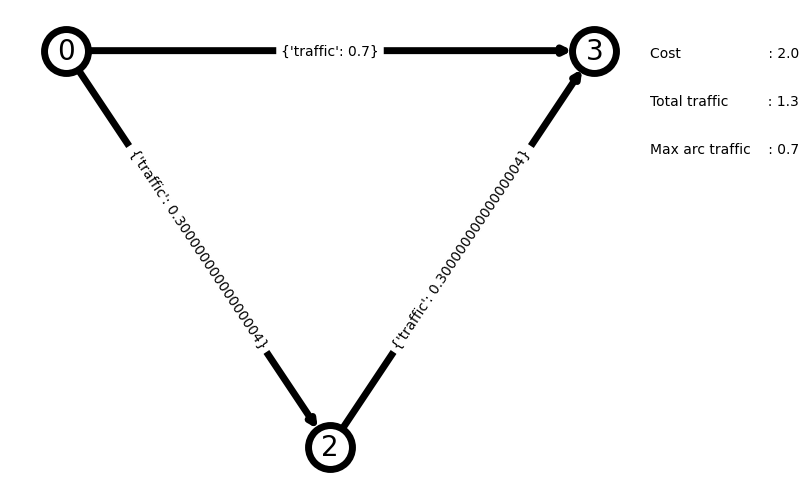

In [35]:
cost = float('inf')
total_traffic = float('inf')
maximum_arc_traffic = 0.7

cost, _, _, result = minimize_routing_cost(graph, routing_demand, max_arc_traffic=maximum_arc_traffic, max_network_traffic=total_traffic)
_, total_traffic, _, result = minimize_total_arc_usage(graph, routing_demand, max_cost=cost, max_arc_traffic=maximum_arc_traffic)
_, _, maximum_arc_traffic, result = minimize_maximum_arc_usage(graph, routing_demand, max_cost=cost, max_network_traffic=total_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/epsilon_0.7_traffic.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {maximum_arc_traffic}")
plt.show()

## The weighted sum method

In [36]:
def minimize_weighted_sum(graph: nx.DiGraph, routing_demand: nx.DiGraph, weight_cost: float = 0.0, weight_network_traffic: float = 0.0, weight_max_arc_traffic: float = 0.0):

    model = gp.Model("multiobjective")

    # Create variables
    x = {}
    for i,j in routing_demand.edges():
        for k,l in graph.edges():
            x[i,j,k,l] = model.addVar(lb = 0.0, ub = 1.0, vtype = GRB.CONTINUOUS , name = f"x[{i},{j},{k},{l}]")

    # Constraints on outgoing traffic from suppliers
    model.addConstrs(gp.quicksum(x[i,j,i,k] for k in graph.succ[i]) == 1 for i,j in routing_demand.edges())
    
    # Constraints on incoming volume to receivent
    model.addConstrs(gp.quicksum(x[i,j,k,j] for k in graph.pred[j]) == 1 for i,j in routing_demand.edges())

    # Constraints on incoming traffic from suppliers (should be 0)
    model.addConstrs(x[i,j,k,i] == 0 for i,j in routing_demand.edges() for k in graph.succ[i] if graph.has_edge(k,i) )

    # Constraint on Kirchhoff's junction rule
    model.addConstrs(gp.quicksum(x[i,j,k,l] for l in graph.succ[k]) == gp.quicksum(x[i,j,l,k] for l in graph.pred[k]) for i,j in routing_demand.edges() for k in graph.nodes() if k not in (i,j))

    # Constraint on arc capacity
    model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges()) <= graph[k][l]["capacity"] for k,l in graph.edges())

    # Minimizing the wighted sum
    max_cost = model.addVar()
    model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] * graph[k][l]["cost"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_cost)
    max_network_traffic = model.addVar()
    model.addConstr(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i,j in routing_demand.edges() for k,l in graph.edges()) <= max_network_traffic)
    max_arc_traffic = model.addVar()
    model.addConstrs(gp.quicksum(x[i,j,k,l] * routing_demand[i][j]["demand"] for i, j in routing_demand.edges()) <= max_arc_traffic for k,l in graph.edges())


    model.setObjective(
        weight_cost * max_cost + weight_network_traffic * max_network_traffic + weight_max_arc_traffic * max_arc_traffic
        , GRB.MINIMIZE
    )


    # Optimize the model (and write it for debugging purposes)
    model.setParam('OutputFlag', 0)
    model.optimize()


    # Display solution
    if model.Status in (GRB.INF_OR_UNBD, GRB.INFEASIBLE, GRB.UNBOUNDED):
        print("The model cannot be solved because it is infeasible or "
              "unbounded")
        sys.exit(1)

    if model.Status != GRB.OPTIMAL:
        print('Optimization was stopped with status ' + str(model.Status))
        sys.exit(1)

    cost = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] * graph[k][l]['cost'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    total_traffic = sum(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    maximum_arc_traffic = max(
        x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges() for k,l in graph.edges()
    )

    result = nx.DiGraph()
    for k in graph:
        for l in graph.succ[k]:
            sum_traffic = sum(
                x[i,j,k,l].X * routing_demand[i][j]['demand'] for i,j in routing_demand.edges()
            )
            if (sum_traffic):
                result.add_edge(k, l, traffic = sum_traffic)

    return (cost, total_traffic, maximum_arc_traffic, result)

Text(1, 0.7, 'Max arc traffic    : 0.5')

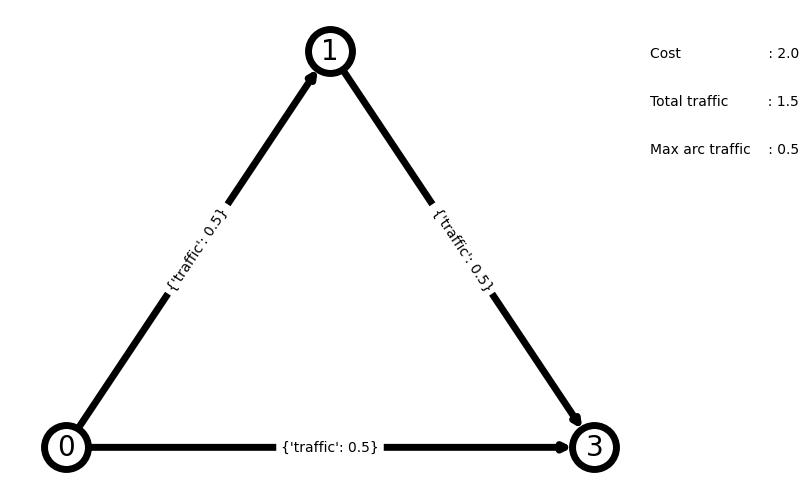

In [37]:
weight_cost = 0
weight_total_traffic = 1
weight_max_arc_traffic = 1

cost, total_traffic, max_arc_traffic, result = minimize_weighted_sum(graph, routing_demand, weight_cost=weight_cost,weight_network_traffic=weight_total_traffic, weight_max_arc_traffic=weight_max_arc_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/weighted_sum_1_1.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {max_arc_traffic}")

Text(1, 0.7, 'Max arc traffic    : 1.0')

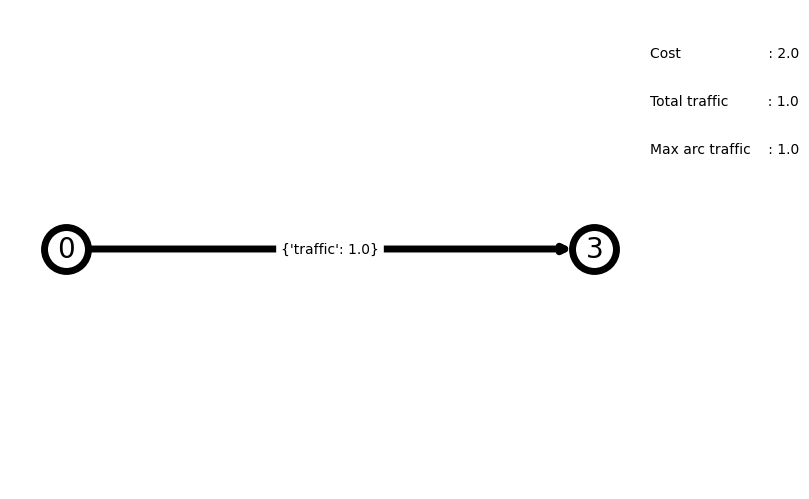

In [38]:
weight_cost = 0
weight_total_traffic = 2
weight_max_arc_traffic = 1

cost, total_traffic, max_arc_traffic, result = minimize_weighted_sum(graph, routing_demand, weight_cost=weight_cost,weight_network_traffic=weight_total_traffic, weight_max_arc_traffic=weight_max_arc_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/weighted_sum_1_1.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {max_arc_traffic}")

In [50]:
import numpy as np 

for i in np.arange(0.4, 0.6, 0.01):
    weight_total_traffic = 1 + i
    weight_max_arc_traffic = 2 - i
    cost, total_traffic, max_arc_traffic, result = minimize_weighted_sum(graph, routing_demand,weight_network_traffic=weight_total_traffic, weight_max_arc_traffic=weight_max_arc_traffic)
    print(f"{round(weight_total_traffic,2)} & {round(weight_max_arc_traffic,2)} & {round(total_traffic,2)} & {round(max_arc_traffic,2)} \\\\")

1.4 & 1.6 & 1.67 & 0.33 \
1.41 & 1.59 & 1.67 & 0.33 \
1.42 & 1.58 & 1.67 & 0.33 \
1.43 & 1.57 & 1.67 & 0.33 \
1.44 & 1.56 & 1.67 & 0.33 \
1.45 & 1.55 & 1.67 & 0.33 \
1.46 & 1.54 & 1.67 & 0.33 \
1.47 & 1.53 & 1.67 & 0.33 \
1.48 & 1.52 & 1.67 & 0.33 \
1.49 & 1.51 & 1.67 & 0.33 \
1.5 & 1.5 & 1.5 & 0.5 \
1.51 & 1.49 & 1.0 & 1.0 \
1.52 & 1.48 & 1.0 & 1.0 \
1.53 & 1.47 & 1.0 & 1.0 \
1.54 & 1.46 & 1.0 & 1.0 \
1.55 & 1.45 & 1.0 & 1.0 \
1.56 & 1.44 & 1.0 & 1.0 \
1.57 & 1.43 & 1.0 & 1.0 \
1.58 & 1.42 & 1.0 & 1.0 \
1.59 & 1.41 & 1.0 & 1.0 \


Text(1, 0.7, 'Max arc traffic    : 0.5')

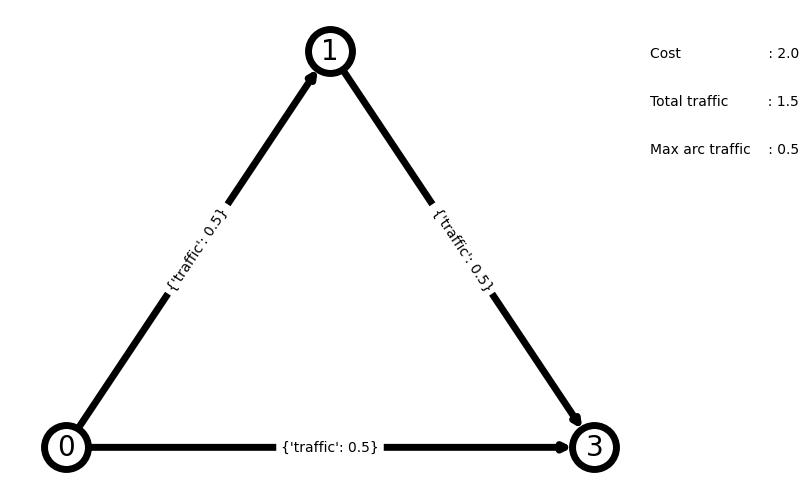

In [51]:
weight_total_traffic = 1
weight_max_arc_traffic = 1

cost, total_traffic, max_arc_traffic, result = minimize_weighted_sum(graph, routing_demand, weight_cost=weight_cost,weight_network_traffic=weight_total_traffic, weight_max_arc_traffic=weight_max_arc_traffic)

nx.draw(result, pos, **options)
nx.draw_networkx_edge_labels(result, pos)
plt.gca()
plt.axis("off")
plt.savefig("../images/weighted_sum_1_1.png")
plt.figtext(1, 0.9, f"Cost                    : {cost}")
plt.figtext(1, 0.8, f"Total traffic         : {total_traffic}")
plt.figtext(1, 0.7, f"Max arc traffic    : {max_arc_traffic}")